In [1]:
import infer.pre_infer as pre_infer
import infer.post_infer as post_infer
import infer.dls_infer as dlsinfer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee


# Step 1: 
Define all of the pertinent paramters in DLS

In [2]:
# parameters
m = 20
c = 1
eta = 1e-3
angle = np.pi/2
n = 1.33
k_b = 1.38e-23
t = 298.15
lambda_0 = 638e-9
beta = 1
start = 5e-10
stop = 1e-8
r = 2.2439608235145855e-09
sigma = 2e-10

In [3]:
right_mean = r*2 + 3e-9
left_mean = r*2 - 3e-9


# Step 2:
Get the simulated time scale, diameter range and associated $\gamma$

get_log_time(), get_distance() and get_gamma() are used to generate a simulated time scale, simulated particle diameter range and associated gamma. I used to have a suite that generates all of these things for me, but I had so far deleted that suite and forgot to stash it somewhere else. That's why I hard-coded them into here.

In [4]:
def get_log_time():
    return np.logspace(-4, -1, num=200, base=10)*0.001

In [5]:
def get_distance(start, stop, m):
    return np.linspace(start, stop, m)

In [6]:
def get_gamma(eta, n, angle, k_b, t, lambda_0):
    return pre_infer.calc_gamma(eta, n, angle, k_b, t, lambda_0)

___

In [7]:
sigma1 = sigma/3

In [8]:
d = get_distance(start, stop, m)
gamma = get_gamma(eta, n, angle, k_b, t, lambda_0)
time = get_log_time()

# Generating the bimodal distribution

In [9]:
f = pre_infer.generate_bimodal_distribution(d, left_mean, sigma1, right_mean, sigma1, c)

This is only formatting for the plots. 

In [10]:
SMALL_SIZE = 11
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



_________________________________________________________________

This part plots the simulated, initial particle size distribution (the starting point) and is optional.

Text(0.5,0,'Particle size (m)')

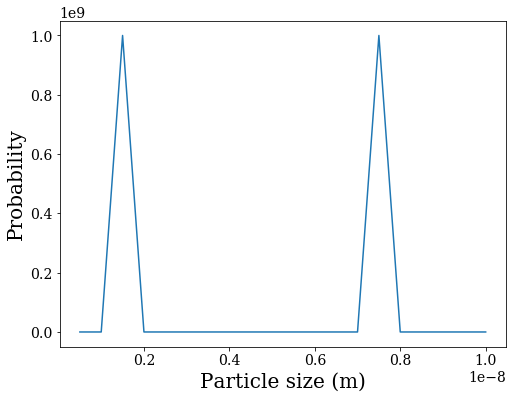

In [11]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(d, f)
ax.set_ylabel('Probability')
ax.set_xlabel('Particle size (m)')

_____________________________________________________

# Step 3:
Append $\beta$ into the array of simulated probability distribution.

In [12]:
theta_input = np.append(f, beta)


__________________________________

# Step 4:
Generate a simulated g2 from the hypothetical size distribution

In [13]:
sim_data = dlsinfer.g2(theta_input, d, gamma, time)

_______________

# Optional: 
Plot the simulated g2 function to check for sensibility.

Text(0.5,0,'Time (s)')

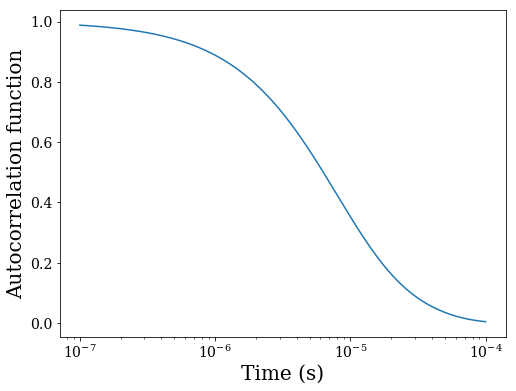

In [14]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
plt.semilogx(time, sim_data)
ax.set_ylabel('Autocorrelation function')
ax.set_xlabel('Time (s)')

____________

# Step 5:
Generate the number of desired dimensions, walkers and steps.

In [15]:
ndim = 21
nwalkers = 100
nsteps = 1000

___

# Step 7:
Create a starting position. 
Previously I had a function that does this, but when I was generating the slides for my presentation, I found bugs that I managed to get to later after my presentation, so for the presentation I crudely generated the starting position. 

Otherwise, you can use dlsinfer.create_start_pos

In [16]:
start_pos = [theta_input + 1e-4*np.absolute(np.random.randn(ndim)) for i in range(nwalkers)]

___

# Step 8:
Create a sampler, can also use dlsinfer.create_sampler

In [17]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, dlsinfer.log_posterior, args=(d, sim_data, m, gamma, time))

___

# Step 9:
Run emcee on the sampler, get the acceptance fraction to check 

In [18]:
result = sampler.run_mcmc(start_pos, nsteps)

In [19]:
sampler.acceptance_fraction

array([0.316, 0.324, 0.314, 0.358, 0.37 , 0.346, 0.341, 0.32 , 0.346,
       0.345, 0.306, 0.316, 0.341, 0.323, 0.329, 0.29 , 0.376, 0.356,
       0.305, 0.343, 0.314, 0.338, 0.329, 0.347, 0.332, 0.342, 0.342,
       0.325, 0.323, 0.306, 0.347, 0.309, 0.345, 0.338, 0.352, 0.298,
       0.304, 0.368, 0.369, 0.343, 0.363, 0.348, 0.325, 0.333, 0.356,
       0.363, 0.29 , 0.363, 0.289, 0.33 , 0.341, 0.336, 0.325, 0.329,
       0.325, 0.317, 0.375, 0.327, 0.345, 0.315, 0.333, 0.338, 0.338,
       0.31 , 0.354, 0.336, 0.337, 0.328, 0.343, 0.336, 0.348, 0.311,
       0.322, 0.338, 0.327, 0.355, 0.316, 0.298, 0.314, 0.331, 0.304,
       0.299, 0.375, 0.352, 0.363, 0.309, 0.348, 0.323, 0.314, 0.312,
       0.336, 0.344, 0.307, 0.379, 0.345, 0.32 , 0.328, 0.349, 0.352,
       0.331])

___

# Step 9:
Chain resultant sampler, use it to create dataframe, and quantile dataframe to 50%

In [20]:
chained_sampler = post_infer.chain(sampler, 900, ndim)
samples_df = post_infer.create_dataframe(chained_sampler, ndim)
q = samples_df.quantile([0.5], axis=0)
q

,f0,f1,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f2,f3,f4,f5,f6,f7,f8,f9
0.5,0.022413,0.263421,0.042134,0.269252,0.349483,0.093316,1.000000e+09,1.535399,0.040796,0.285661,0.252963,0.226909,1.000000e+09,0.426914,0.410318,0.517353,0.184663,0.058169,0.791916,0.431085


___

# Step 10:
Extract the array for probability values from the quantiled dataframe

In [21]:
inferred = post_infer.get_infer_f(q, m)
inferred

array([2.24127657e-02, 2.63420737e-01, 1.00000000e+09, 4.26914026e-01,
       4.10317536e-01, 5.17353236e-01, 1.84662908e-01, 5.81688547e-02,
       7.91915596e-01, 4.31085025e-01, 4.21342116e-02, 2.69251558e-01,
       3.49483314e-01, 9.33158311e-02, 1.00000000e+09, 1.53539868e+00,
       4.07958065e-02, 2.85660880e-01, 2.52962709e-01, 2.26908727e-01])

_______

# Step 11:
Plot the result against the simulated size distribution

Text(0.5,0,'Particle size (m)')

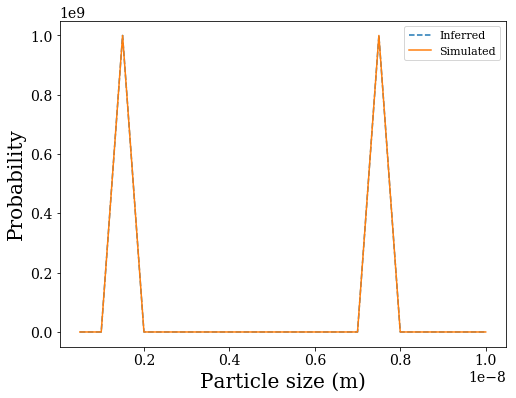

In [22]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(d, inferred, '--', label='Inferred')
plt.plot(d, f, label='Simulated')
plt.legend()

ax.set_ylabel("Probability")
ax.set_xlabel("Particle size (m)")

______